In [1199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
# Some sklearn tools for preprocessing and building a pipeline. 
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.svm import SVC

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [1201]:
df = pd.read_csv('Data/MU.csv', sep = ',')

In [1203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1157 non-null   object 
 1   Open                 1157 non-null   float64
 2   High                 1157 non-null   float64
 3   Low                  1157 non-null   float64
 4   Close                1157 non-null   float64
 5   Daily % Change       1157 non-null   float64
 6   Volume               1157 non-null   int64  
 7   Dividends            1157 non-null   float64
 8   Stock Splits         1157 non-null   int64  
 9   DDR3 2Gb 16DP 1866   1157 non-null   float64
 10  DDR3 2Gb 8DP 1866    1157 non-null   float64
 11  DDR3 4Gb 16DP 1866   1157 non-null   float64
 12  DDR3 4Gb 8DP 1866    1157 non-null   float64
 13  DDR4 4Gb 16DP 2666   1157 non-null   float64
 14  DDR4 4Gb 8DP 2666    1157 non-null   float64
 15  DDR4 8Gb 8DP 2666    1157 non-null   f

In [1205]:
# Remove the Hour and Minutes from the date stamp.  Unnecessary in our analysis
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.head()

,Date,Open,High,Low,Close,Daily % Change,Volume,Dividends,Stock Splits,DDR3 2Gb 16DP 1866,...,DDR4 4Gb 16DP 2666,DDR4 4Gb 8DP 2666,DDR4 8Gb 8DP 2666,DDR4 8Gb 16DP 2666,DDR4 8Gb 8DP 3200,DDR4 8Gb 16DP 3200,DDR4 16Gb 8DP 2666,DDR4 16Gb 16DP 3200,DDR4 16Gb 8DP 3200,DDR5 16Gb 8DP 5600
0,2020-01-02,53.869728,54.498293,53.535804,54.400078,0.029937,20173200,0.0,0,0.995,...,1.710,1.760,3.200,3.202,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-03,53.192068,54.321517,53.034927,53.555454,-0.015526,16815800,0.0,0,0.997,...,1.723,1.793,3.240,3.227,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-06,52.789397,53.172427,52.209941,52.612614,-0.017605,18768700,0.0,0,0.997,...,1.723,1.820,3.257,3.233,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-07,54.390257,57.356285,54.370614,57.228607,0.087735,49908200,0.0,0,1.003,...,1.757,1.900,3.323,3.233,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-08,57.051825,57.346462,56.040234,56.492012,-0.012871,29730800,0.0,0,1.003,...,1.800,1.953,3.357,3.233,NaN,NaN,NaN,NaN,NaN,NaN


In [1207]:
# NaN number in the pricing means that the specific DRAM has not been introduced to the marketplace.  It is not widely available, so the price is NAN.
# For our analysis purposes, we will just assume the price of DRAM is $0 dollars.
#df.fillna(0, inplace=True)
df.head()

,Date,Open,High,Low,Close,Daily % Change,Volume,Dividends,Stock Splits,DDR3 2Gb 16DP 1866,...,DDR4 4Gb 16DP 2666,DDR4 4Gb 8DP 2666,DDR4 8Gb 8DP 2666,DDR4 8Gb 16DP 2666,DDR4 8Gb 8DP 3200,DDR4 8Gb 16DP 3200,DDR4 16Gb 8DP 2666,DDR4 16Gb 16DP 3200,DDR4 16Gb 8DP 3200,DDR5 16Gb 8DP 5600
0,2020-01-02,53.869728,54.498293,53.535804,54.400078,0.029937,20173200,0.0,0,0.995,...,1.710,1.760,3.200,3.202,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-03,53.192068,54.321517,53.034927,53.555454,-0.015526,16815800,0.0,0,0.997,...,1.723,1.793,3.240,3.227,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-06,52.789397,53.172427,52.209941,52.612614,-0.017605,18768700,0.0,0,0.997,...,1.723,1.820,3.257,3.233,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-07,54.390257,57.356285,54.370614,57.228607,0.087735,49908200,0.0,0,1.003,...,1.757,1.900,3.323,3.233,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-08,57.051825,57.346462,56.040234,56.492012,-0.012871,29730800,0.0,0,1.003,...,1.800,1.953,3.357,3.233,NaN,NaN,NaN,NaN,NaN,NaN


In [1209]:
# drop the Dividends and Stock splits since it is not needed in our analysis
df = df.drop('Dividends', axis=1)
df = df.drop('Stock Splits', axis=1)

In [1211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1157 non-null   object 
 1   Open                 1157 non-null   float64
 2   High                 1157 non-null   float64
 3   Low                  1157 non-null   float64
 4   Close                1157 non-null   float64
 5   Daily % Change       1157 non-null   float64
 6   Volume               1157 non-null   int64  
 7   DDR3 2Gb 16DP 1866   1157 non-null   float64
 8   DDR3 2Gb 8DP 1866    1157 non-null   float64
 9   DDR3 4Gb 16DP 1866   1157 non-null   float64
 10  DDR3 4Gb 8DP 1866    1157 non-null   float64
 11  DDR4 4Gb 16DP 2666   1157 non-null   float64
 12  DDR4 4Gb 8DP 2666    1157 non-null   float64
 13  DDR4 8Gb 8DP 2666    1157 non-null   float64
 14  DDR4 8Gb 16DP 2666   1157 non-null   float64
 15  DDR4 8Gb 8DP 3200    763 non-null    f

In [1213]:
# In the memory market, we can standardize the data by finding out the $ per Gb.  This make sure regardless of the technology (DDR3/DDR4/DDR5)
# or die density (2Gb/4Gb/8Gb/16Gb) that we standardize to $ per Gb.  To Calculate, we simiply divide the price $ by the number of X Gb as titled in 
# the column

#DDR3 2Gb are below
df['DDR3 2Gb 16DP 1866'] = df['DDR3 2Gb 16DP 1866'].div(2)
df['DDR3 2Gb 8DP 1866'] = df['DDR3 2Gb 8DP 1866'].div(2)

#DDR3 4Gb are below
df['DDR3 4Gb 16DP 1866'] = df['DDR3 4Gb 16DP 1866'].div(4)
df['DDR3 4Gb 8DP 1866'] = df['DDR3 4Gb 8DP 1866'].div(4)

#DDR4 4Gb are below
df['DDR4 4Gb 16DP 2666'] = df['DDR4 4Gb 16DP 2666'].div(4)
df['DDR4 4Gb 8DP 2666'] = df['DDR4 4Gb 8DP 2666'].div(4)

#8Gb are below
df['DDR4 8Gb 8DP 2666'] = df['DDR4 8Gb 8DP 2666'].div(8)
df['DDR4 8Gb 16DP 2666'] = df['DDR4 8Gb 16DP 2666'].div(8)

df['DDR4 8Gb 8DP 3200'] = df['DDR4 8Gb 8DP 3200'].div(8)
df['DDR4 8Gb 16DP 3200'] = df['DDR4 8Gb 16DP 3200'].div(8)

# 16Gb are below
df['DDR4 16Gb 8DP 2666'] = df['DDR4 16Gb 8DP 2666'].div(16)

df['DDR4 16Gb 16DP 3200'] = df['DDR4 16Gb 16DP 3200'].div(16)
df['DDR4 16Gb 8DP 3200'] = df['DDR4 16Gb 8DP 3200'].div(16)

df['DDR5 16Gb 8DP 5600'] = df['DDR5 16Gb 8DP 5600'].div(16)

In [1215]:
print(df)

            Date        Open        High        Low       Close  \
0     2020-01-02   53.869728   54.498293  53.535804   54.400078   
1     2020-01-03   53.192068   54.321517  53.034927   53.555454   
2     2020-01-06   52.789397   53.172427  52.209941   52.612614   
3     2020-01-07   54.390257   57.356285  54.370614   57.228607   
4     2020-01-08   57.051825   57.346462  56.040234   56.492012   
...          ...         ...         ...        ...         ...   
1152  2024-08-01  107.060400  107.739600  99.838400  101.396700   
1153  2024-08-02   97.051500   97.581000  90.968300   92.596500   
1154  2024-08-05   87.532200   92.147000  84.815200   90.319100   
1155  2024-08-06   89.100400   90.758600  87.052700   88.900700   
1156  2024-08-07   93.275800   93.475500  86.483400   86.703100   

      Daily % Change    Volume  DDR3 2Gb 16DP 1866  DDR3 2Gb 8DP 1866  \
0           0.029937  20173200              0.4975              0.546   
1          -0.015526  16815800              0.498

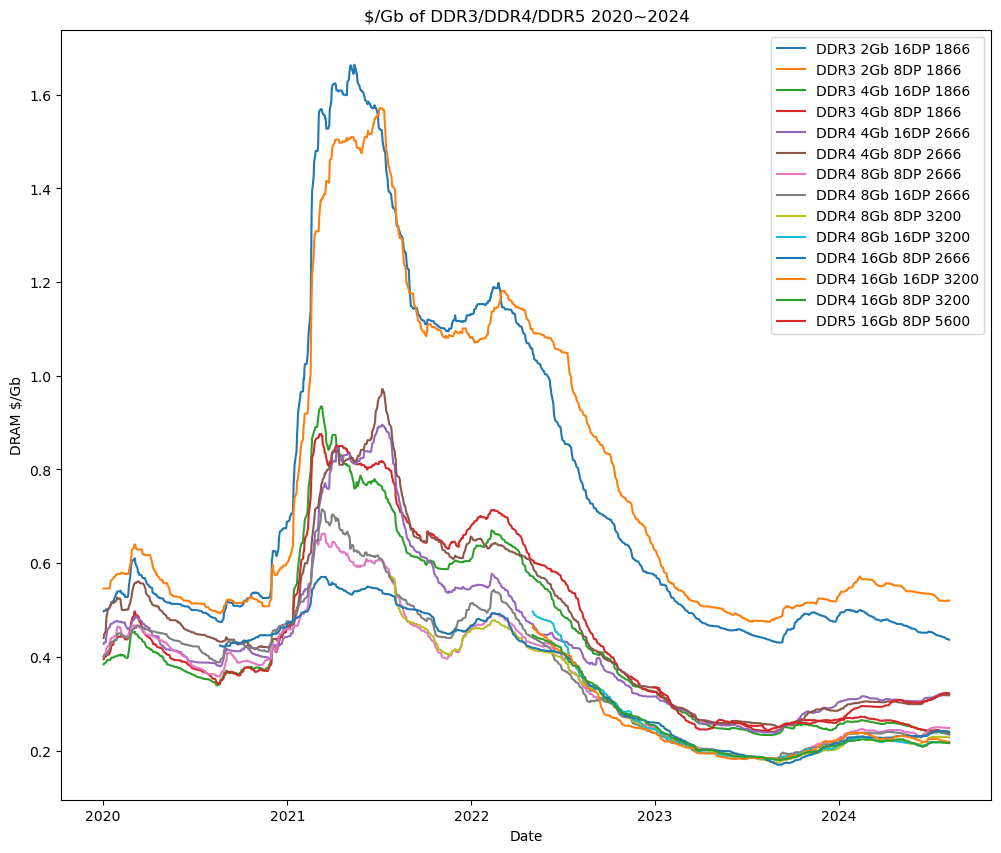

In [1217]:
#plot the dram prices based on all DDR SKU
selected_columns = ['Date', 'DDR3 2Gb 16DP 1866','DDR3 2Gb 8DP 1866','DDR3 4Gb 16DP 1866','DDR3 4Gb 8DP 1866','DDR4 4Gb 16DP 2666','DDR4 4Gb 8DP 2666',
                    'DDR4 8Gb 8DP 2666', 'DDR4 8Gb 16DP 2666', 'DDR4 8Gb 8DP 3200','DDR4 8Gb 16DP 3200', 'DDR4 16Gb 8DP 2666','DDR4 16Gb 16DP 3200',
                    'DDR4 16Gb 8DP 3200','DDR5 16Gb 8DP 5600']
#df1 = df[['','']].copy()
df1 = df[selected_columns].copy()
fig, ax = plt.subplots(figsize=(12, 10))
sns.lineplot(data=df1, x='Date', y='DDR3 2Gb 16DP 1866', label='DDR3 2Gb 16DP 1866', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR3 2Gb 8DP 1866', label='DDR3 2Gb 8DP 1866', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR3 4Gb 16DP 1866', label='DDR3 4Gb 16DP 1866', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR3 4Gb 8DP 1866', label='DDR3 4Gb 8DP 1866', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 4Gb 16DP 2666', label='DDR4 4Gb 16DP 2666', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 4Gb 8DP 2666', label='DDR4 4Gb 8DP 2666', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 8Gb 8DP 2666', label='DDR4 8Gb 8DP 2666', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 8Gb 16DP 2666', label='DDR4 8Gb 16DP 2666', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 8Gb 8DP 3200', label='DDR4 8Gb 8DP 3200', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 8Gb 16DP 3200', label='DDR4 8Gb 16DP 3200', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 16Gb 8DP 2666', label='DDR4 16Gb 8DP 2666', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 16Gb 16DP 3200', label='DDR4 16Gb 16DP 3200', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 16Gb 8DP 3200', label='DDR4 16Gb 8DP 3200', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR5 16Gb 8DP 5600', label='DDR5 16Gb 8DP 5600', ax=ax)

plt.xlabel('Date')
plt.ylabel('DRAM $/Gb')
plt.title('$/Gb of DDR3/DDR4/DDR5 2020~2024')
plt.legend()
plt.show()

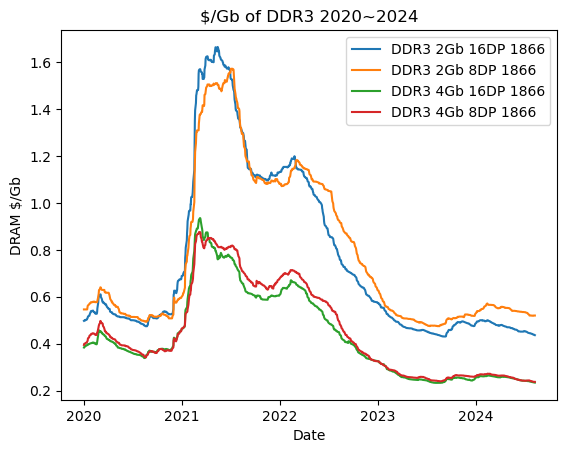

In [1219]:
sns.lineplot(data=df1, x='Date', y='DDR3 2Gb 16DP 1866', label='DDR3 2Gb 16DP 1866')
sns.lineplot(data=df1, x='Date', y='DDR3 2Gb 8DP 1866', label='DDR3 2Gb 8DP 1866')
sns.lineplot(data=df1, x='Date', y='DDR3 4Gb 16DP 1866', label='DDR3 4Gb 16DP 1866')
sns.lineplot(data=df1, x='Date', y='DDR3 4Gb 8DP 1866', label='DDR3 4Gb 8DP 1866')

plt.xlabel('Date')
plt.ylabel('DRAM $/Gb')
plt.title('$/Gb of DDR3 2020~2024')
plt.legend()
plt.show()

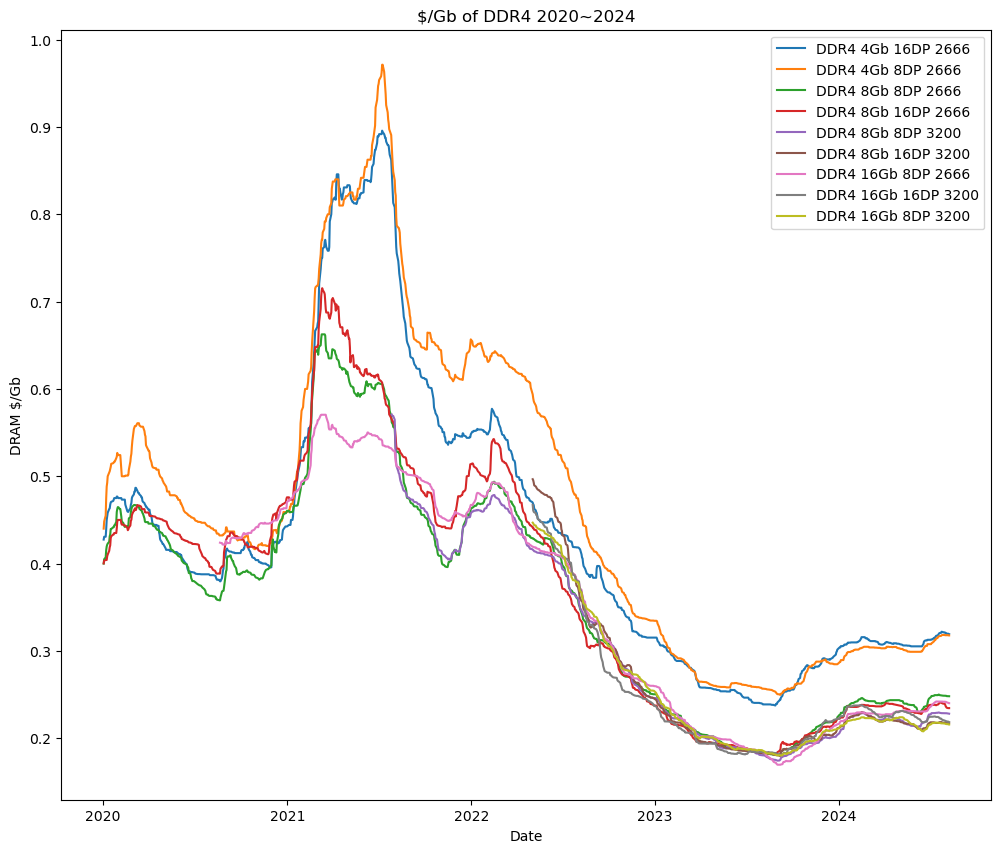

In [1221]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.lineplot(data=df1, x='Date', y='DDR4 4Gb 16DP 2666', label='DDR4 4Gb 16DP 2666', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 4Gb 8DP 2666', label='DDR4 4Gb 8DP 2666', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 8Gb 8DP 2666', label='DDR4 8Gb 8DP 2666', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 8Gb 16DP 2666', label='DDR4 8Gb 16DP 2666', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 8Gb 8DP 3200', label='DDR4 8Gb 8DP 3200', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 8Gb 16DP 3200', label='DDR4 8Gb 16DP 3200', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 16Gb 8DP 2666', label='DDR4 16Gb 8DP 2666', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 16Gb 16DP 3200', label='DDR4 16Gb 16DP 3200', ax=ax)
sns.lineplot(data=df1, x='Date', y='DDR4 16Gb 8DP 3200', label='DDR4 16Gb 8DP 3200', ax=ax)

plt.xlabel('Date')
plt.ylabel('DRAM $/Gb')
plt.title('$/Gb of DDR4 2020~2024')
plt.legend()
plt.show()

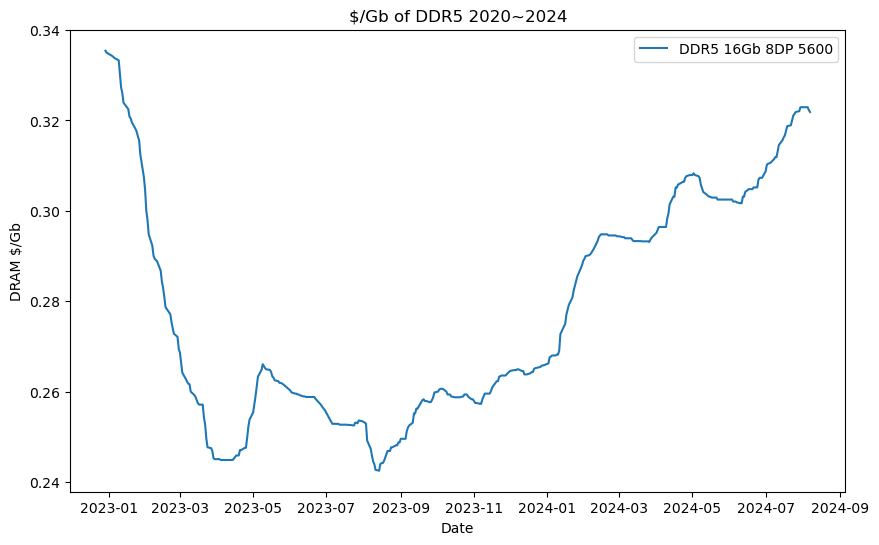

In [1223]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df1, x='Date', y='DDR5 16Gb 8DP 5600', label='DDR5 16Gb 8DP 5600', ax=ax)

plt.xlabel('Date')
plt.ylabel('DRAM $/Gb')
plt.title('$/Gb of DDR5 2020~2024')
plt.legend()
plt.show()

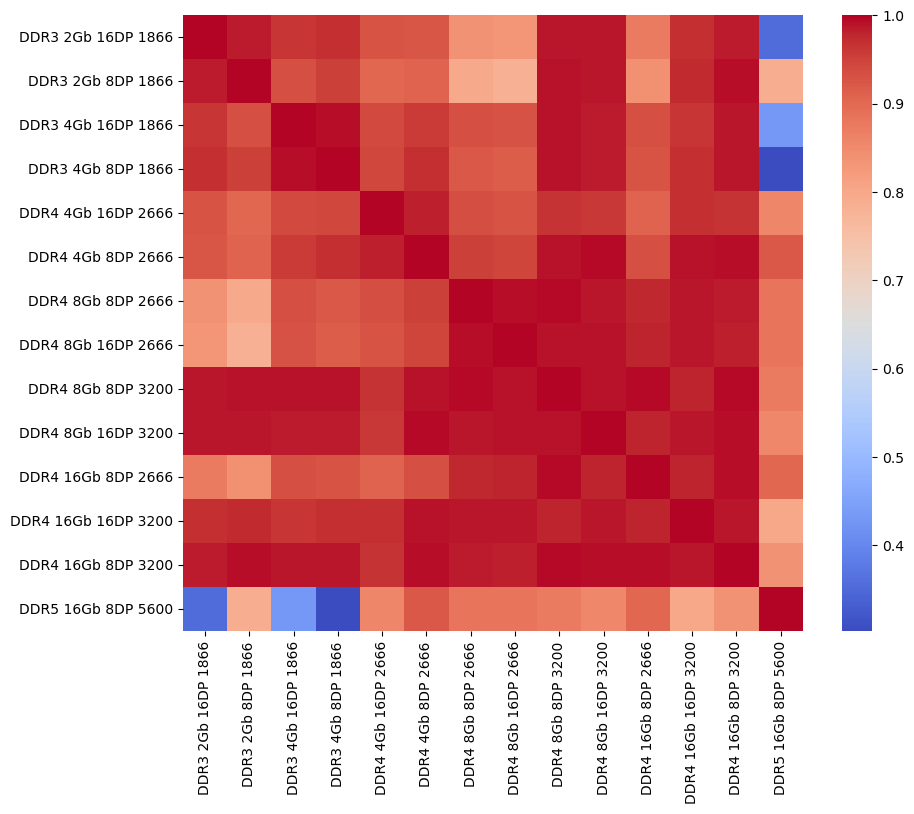

In [1225]:
#find and plat the Correlation heatmap to see the $/Gb DRAM price relationship
#drop the Date as we won't use it in Corr()
# high correlation means that $/Gb of kinds of DRAM are highly related.  Therefore, it would be possible to take an average of the DRAM prices without
# impacting data analysis
# df2 will only have $/Gb of DRAM data
df2 = df1.drop('Date', axis=1)
corr_matrix = df2.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, cmap = 'coolwarm')
plt.show()

In [1227]:
corr_matrix.style.background_gradient(cmap='coolwarm')

,DDR3 2Gb 16DP 1866,DDR3 2Gb 8DP 1866,DDR3 4Gb 16DP 1866,DDR3 4Gb 8DP 1866,DDR4 4Gb 16DP 2666,DDR4 4Gb 8DP 2666,DDR4 8Gb 8DP 2666,DDR4 8Gb 16DP 2666,DDR4 8Gb 8DP 3200,DDR4 8Gb 16DP 3200,DDR4 16Gb 8DP 2666,DDR4 16Gb 16DP 3200,DDR4 16Gb 8DP 3200,DDR5 16Gb 8DP 5600
DDR3 2Gb 16DP 1866,1.000000,0.984545,0.964440,0.967485,0.928999,0.925882,0.837488,0.832491,0.987675,0.988398,0.872899,0.968519,0.984974,0.353662
DDR3 2Gb 8DP 1866,0.984545,1.000000,0.934232,0.951054,0.903468,0.909798,0.797329,0.782447,0.991467,0.988000,0.839515,0.973428,0.994402,0.789776
DDR3 4Gb 16DP 1866,0.964440,0.934232,1.000000,0.991919,0.941960,0.957184,0.932532,0.929464,0.990058,0.984483,0.932552,0.962230,0.987578,0.428675
DDR3 4Gb 8DP 1866,0.967485,0.951054,0.991919,1.000000,0.943193,0.968337,0.922682,0.917261,0.990622,0.984568,0.928714,0.969491,0.987992,0.302957
DDR4 4Gb 16DP 2666,0.928999,0.903468,0.941960,0.943193,1.000000,0.982782,0.935790,0.927486,0.966787,0.959956,0.907506,0.968139,0.966719,0.857701
DDR4 4Gb 8DP 2666,0.925882,0.909798,0.957184,0.968337,0.982782,1.000000,0.953263,0.945885,0.990330,0.995478,0.932119,0.991613,0.993011,0.922823
DDR4 8Gb 8DP 2666,0.837488,0.797329,0.932532,0.922682,0.935790,0.953263,1.000000,0.993624,0.996106,0.986691,0.975718,0.987235,0.985941,0.884163
DDR4 8Gb 16DP 2666,0.832491,0.782447,0.929464,0.917261,0.927486,0.945885,0.993624,1.000000,0.990574,0.989877,0.979520,0.986972,0.983279,0.883729
DDR4 8Gb 8DP 3200,0.987675,0.991467,0.990058,0.990622,0.966787,0.990330,0.996106,0.990574,1.000000,0.989365,0.995119,0.979840,0.995869,0.872361
DDR4 8Gb 16DP 3200,0.988398,0.988000,0.984483,0.984568,0.959956,0.995478,0.986691,0.989877,0.989365,1.000000,0.980342,0.988384,0.993887,0.853633


In [1229]:
# Taking the mean of all $/Gb prices into a Generic DRAM price $/Gb
df2['Avg DRAM $/Gb'] = df2.mean(axis=1)
df2['% Change DRAM $/Gb'] = df2['Avg DRAM $/Gb'].pct_change()
df2

,DDR3 2Gb 16DP 1866,DDR3 2Gb 8DP 1866,DDR3 4Gb 16DP 1866,DDR3 4Gb 8DP 1866,DDR4 4Gb 16DP 2666,DDR4 4Gb 8DP 2666,DDR4 8Gb 8DP 2666,DDR4 8Gb 16DP 2666,DDR4 8Gb 8DP 3200,DDR4 8Gb 16DP 3200,DDR4 16Gb 8DP 2666,DDR4 16Gb 16DP 3200,DDR4 16Gb 8DP 3200,DDR5 16Gb 8DP 5600,Avg DRAM $/Gb,% Change DRAM $/Gb
0,0.4975,0.546,0.38375,0.39475,0.42750,0.44000,0.400000,0.400250,NaN,NaN,NaN,NaN,NaN,NaN,0.436219,NaN
1,0.4985,0.546,0.38625,0.39950,0.43075,0.44825,0.405000,0.403375,NaN,NaN,NaN,NaN,NaN,NaN,0.439703,0.007988
2,0.4985,0.546,0.38750,0.40025,0.43075,0.45500,0.407125,0.404125,NaN,NaN,NaN,NaN,NaN,NaN,0.441156,0.003305
3,0.5015,0.546,0.38825,0.40150,0.43925,0.47500,0.415375,0.404125,NaN,NaN,NaN,NaN,NaN,NaN,0.446375,0.011830
4,0.5015,0.546,0.39125,0.40275,0.45000,0.48825,0.419625,0.404125,NaN,NaN,NaN,NaN,NaN,NaN,0.450437,0.009101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,0.4390,0.519,0.23575,0.23775,0.31975,0.31800,0.248625,0.236000,0.228625,0.217375,0.241625,0.219625,0.216375,0.322937,0.285746,-0.000968
1153,0.4380,0.520,0.23525,0.23775,0.31975,0.31800,0.248250,0.235000,0.228625,0.217375,0.241125,0.219250,0.216188,0.322937,0.285536,-0.000734
1154,0.4380,0.520,0.23500,0.23750,0.31975,0.31800,0.248125,0.234500,0.228250,0.217250,0.240625,0.219062,0.216188,0.322937,0.285371,-0.000578
1155,0.4370,0.520,0.23450,0.23750,0.31950,0.31775,0.248125,0.234500,0.228125,0.217250,0.240125,0.218750,0.215750,0.322313,0.285085,-0.001001


In [1231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1157 non-null   object 
 1   Open                 1157 non-null   float64
 2   High                 1157 non-null   float64
 3   Low                  1157 non-null   float64
 4   Close                1157 non-null   float64
 5   Daily % Change       1157 non-null   float64
 6   Volume               1157 non-null   int64  
 7   DDR3 2Gb 16DP 1866   1157 non-null   float64
 8   DDR3 2Gb 8DP 1866    1157 non-null   float64
 9   DDR3 4Gb 16DP 1866   1157 non-null   float64
 10  DDR3 4Gb 8DP 1866    1157 non-null   float64
 11  DDR4 4Gb 16DP 2666   1157 non-null   float64
 12  DDR4 4Gb 8DP 2666    1157 non-null   float64
 13  DDR4 8Gb 8DP 2666    1157 non-null   float64
 14  DDR4 8Gb 16DP 2666   1157 non-null   float64
 15  DDR4 8Gb 8DP 3200    763 non-null    f

In [1233]:
#Collect the data that is most relevant to our analysis
selected_columns = ['Date', 'Close', 'Daily % Change']
df3 = df[selected_columns].copy()
df3['Avg DRAM $/Gb'] = df2['Avg DRAM $/Gb']
df3['% Change DRAM $/Gb'] = df2['% Change DRAM $/Gb']
df3

,Date,Close,Daily % Change,Avg DRAM $/Gb,% Change DRAM $/Gb
0,2020-01-02,54.400078,0.029937,0.436219,NaN
1,2020-01-03,53.555454,-0.015526,0.439703,0.007988
2,2020-01-06,52.612614,-0.017605,0.441156,0.003305
3,2020-01-07,57.228607,0.087735,0.446375,0.011830
4,2020-01-08,56.492012,-0.012871,0.450437,0.009101
...,...,...,...,...,...
1152,2024-08-01,101.396700,-0.075669,0.285746,-0.000968
1153,2024-08-02,92.596500,-0.086790,0.285536,-0.000734
1154,2024-08-05,90.319100,-0.024595,0.285371,-0.000578
1155,2024-08-06,88.900700,-0.015704,0.285085,-0.001001


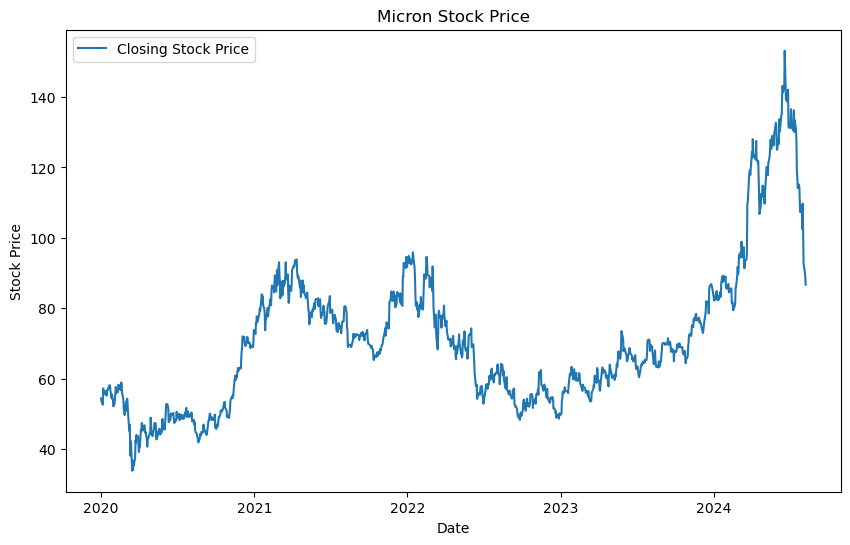

In [1235]:
# Plot Micron Stock Prices
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df3, x='Date', y='Close', label='Closing Stock Price', ax=ax)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Micron Stock Price')
plt.legend()
plt.show()

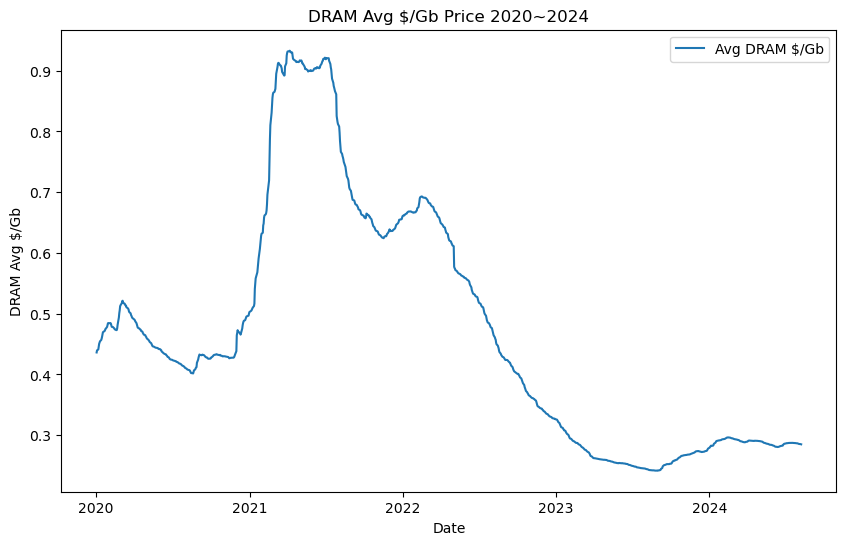

In [1237]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df3, x='Date', y='Avg DRAM $/Gb', label='Avg DRAM $/Gb', ax=ax)

plt.xlabel('Date')
plt.ylabel('DRAM Avg $/Gb')
plt.title('DRAM Avg $/Gb Price 2020~2024')
plt.legend()
plt.show()

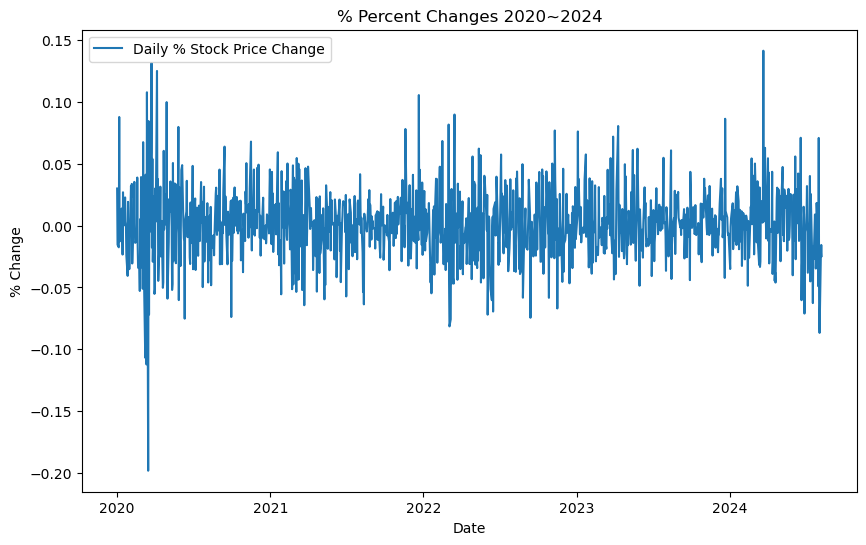

In [1239]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df3, x='Date', y='Daily % Change', label='Daily % Stock Price Change', ax=ax)

plt.xlabel('Date')
plt.ylabel('% Change')
plt.title('% Percent Changes 2020~2024')
plt.legend()
plt.show()

In [1241]:
Avg = df3['% Change DRAM $/Gb'].mean()
Avg

-0.0003527584252641923

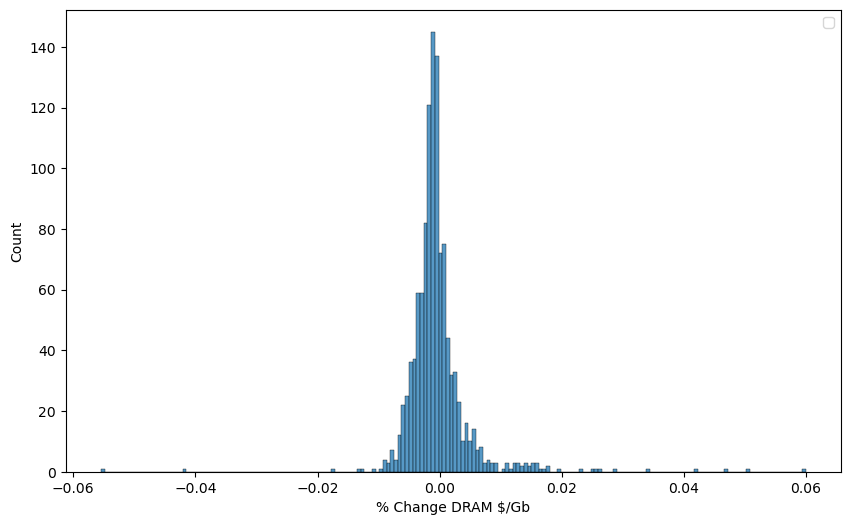

In [1243]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df3, x='% Change DRAM $/Gb', ax=ax)
plt.legend()
plt.show()

<Axes: xlabel='% Change DRAM $/Gb'>

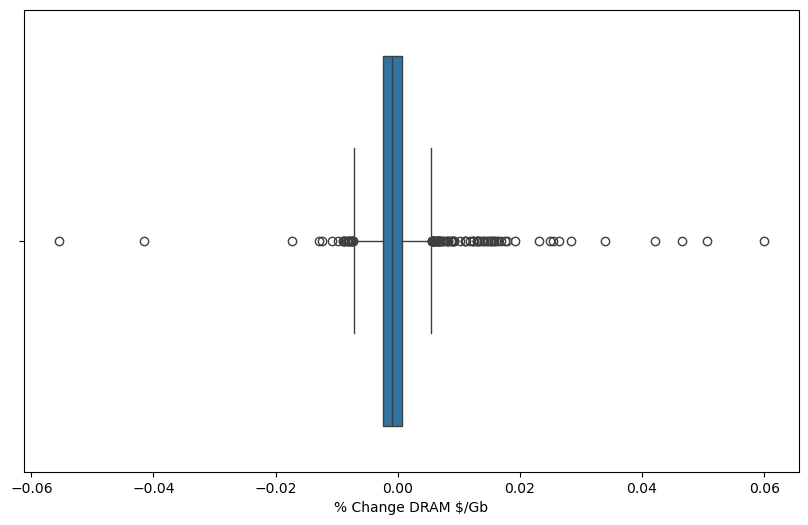

In [1245]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df3, x= '% Change DRAM $/Gb', ax=ax)

In [1247]:
#Find First Quartile and third Quartile
first_quartile = df3['% Change DRAM $/Gb'].quantile(0.1)
print(first_quartile)

third_quartile = df3['% Change DRAM $/Gb'].quantile(0.9)
print(third_quartile)

-0.004461962350157556
0.003535478473211451


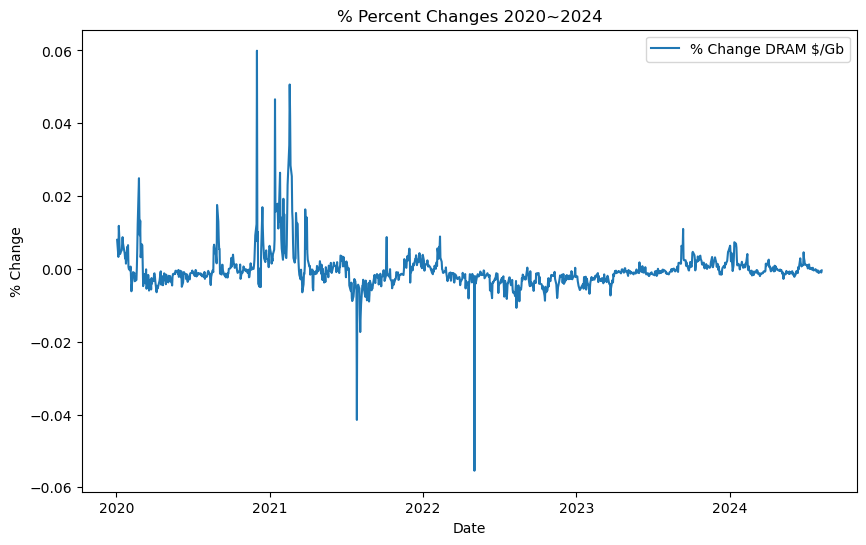

In [1249]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df3, x='Date', y='% Change DRAM $/Gb', label='% Change DRAM $/Gb', ax=ax)


plt.xlabel('Date')
plt.ylabel('% Change')
plt.title('% Percent Changes 2020~2024')
plt.legend()
plt.show()

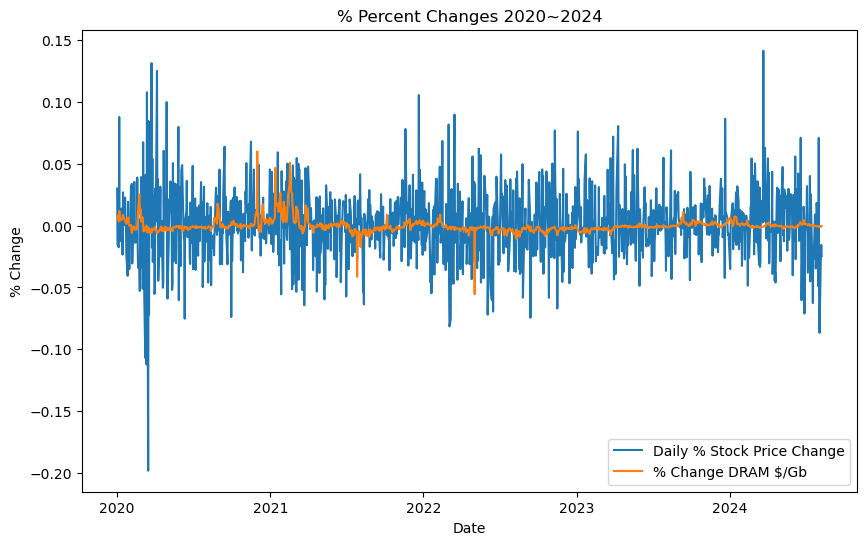

In [1252]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df3, x='Date', y='Daily % Change', label='Daily % Stock Price Change', ax=ax)
sns.lineplot(data=df3, x='Date', y='% Change DRAM $/Gb', label='% Change DRAM $/Gb', ax=ax)

plt.xlabel('Date')
plt.ylabel('% Change')
plt.title('% Percent Changes 2020~2024')
plt.legend()
plt.show()

In [1254]:
# Check Correlation between the % changes to see if there is a relationship.  Looks like most of the time there are correlation between
# Close Stock price and Avg DRAM $/Gb.  However, from earlier boxplot, we can see that there are many outliers in Avg DRAM $/Gb.  
# Questions can be asked if big % changes in the Avg DRAM $/Gb, would the stock price be highley influenced
df4 = df3.drop('Date', axis=1)
corr_matrix = df4.corr()

corr_matrix.style.background_gradient(cmap='coolwarm')

,Close,Daily % Change,Avg DRAM $/Gb,% Change DRAM $/Gb
Close,1.000000,0.044313,0.059485,0.147233
Daily % Change,0.044313,1.000000,-0.026817,0.030737
Avg DRAM $/Gb,0.059485,-0.026817,1.000000,0.048474
% Change DRAM $/Gb,0.147233,0.030737,0.048474,1.000000


In [1256]:
# maybe only large % movements in the DRAM prices would move the market.  Small % movements are negligble
df5 = df4.loc[(df4['% Change DRAM $/Gb'] <= -0.004 )|(df4['% Change DRAM $/Gb'] >= 0.004)]
corr_matrix = df5.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,Close,Daily % Change,Avg DRAM $/Gb,% Change DRAM $/Gb
Close,1.000000,0.041271,0.527413,0.273387
Daily % Change,0.041271,1.000000,-0.010267,0.052430
Avg DRAM $/Gb,0.527413,-0.010267,1.000000,0.073589
% Change DRAM $/Gb,0.273387,0.052430,0.073589,1.000000


In [1258]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 1 to 1126
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               250 non-null    float64
 1   Daily % Change      250 non-null    float64
 2   Avg DRAM $/Gb       250 non-null    float64
 3   % Change DRAM $/Gb  250 non-null    float64
dtypes: float64(4)
memory usage: 9.8 KB


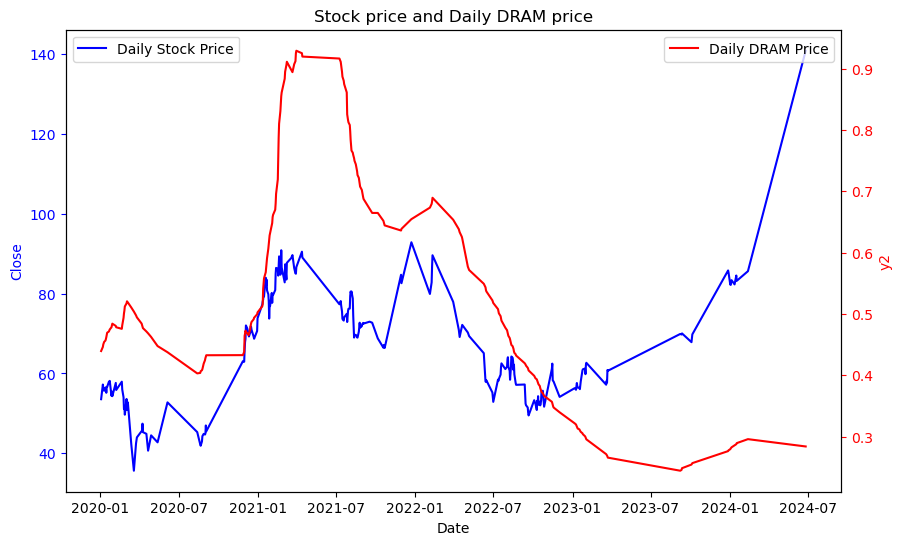

In [1260]:
df5 = df3.loc[(df3['% Change DRAM $/Gb'] <= -0.004 )|(df3['% Change DRAM $/Gb'] >= 0.004)]

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df5, x='Date', y='Close', label='Daily Stock Price', ax=ax1, color='blue')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', colors='blue')

ax2 = ax1.twinx()
sns.lineplot(data=df5, x='Date', y='Avg DRAM $/Gb', label='Daily DRAM Price', ax=ax2, color='red')
ax2.set_ylabel('y2', color='red')
ax2.tick_params(axis='y', colors='red')

plt.xlabel('Date')
plt.title('Stock price and Daily DRAM price')
plt.legend()
plt.show()

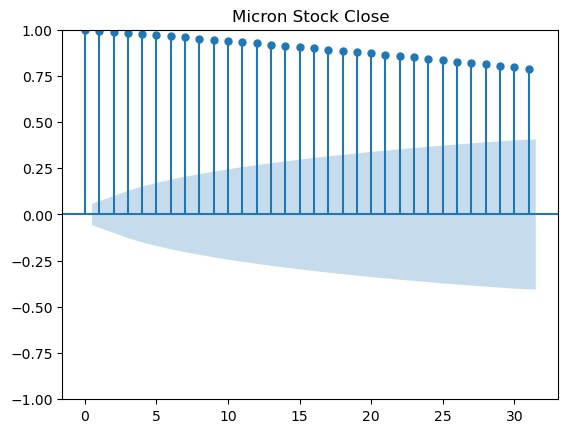

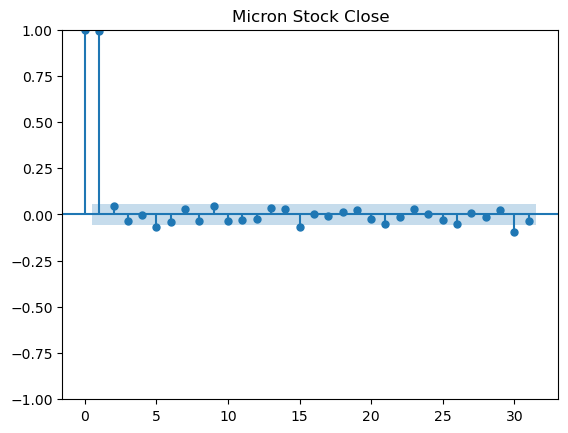

In [1262]:
# Plot Autocorrelation and PACF on the time series.  Let's take a look at the autocorrelation of the time series
plot_acf(df3['Close'], title="Micron Stock Close")
plot_pacf(df3['Close'], title="Micron Stock Close")
plt.show()

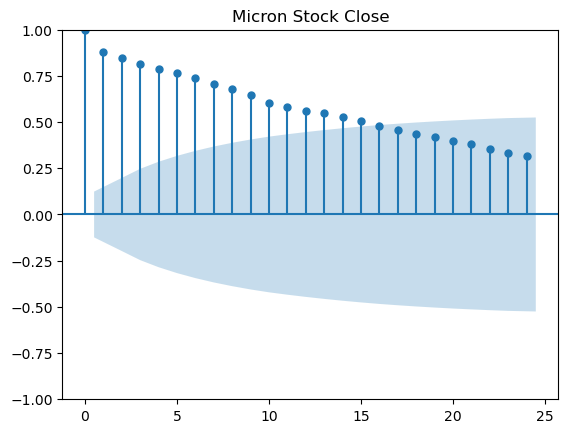

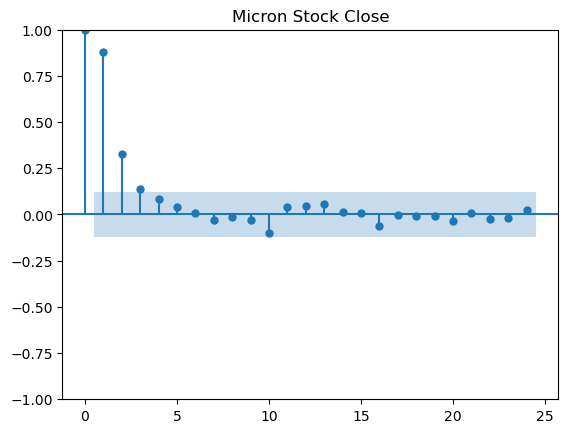

In [1264]:
plot_acf(df5['Close'], title="Micron Stock Close")
plot_pacf(df5['Close'], title="Micron Stock Close")
plt.show()

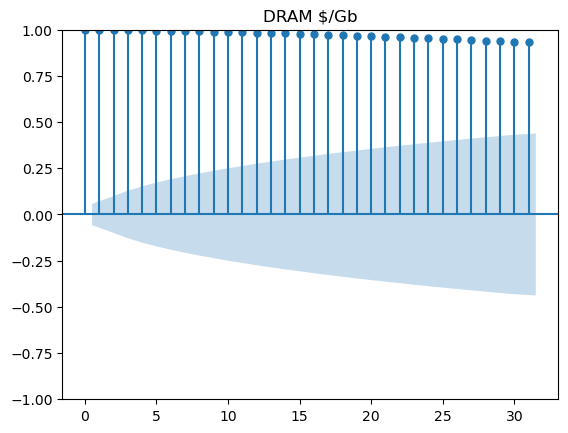

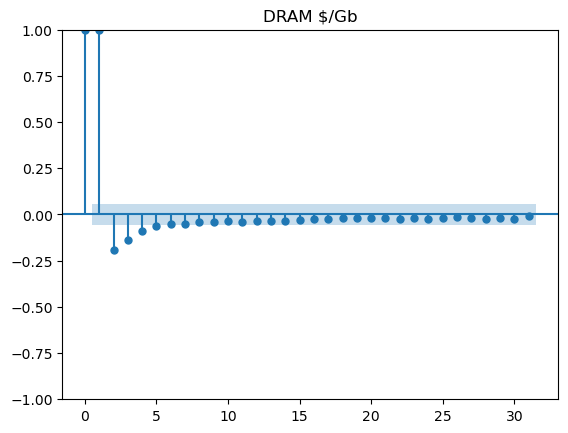

In [1266]:
plot_acf(df3['Avg DRAM $/Gb'], title="DRAM $/Gb")
plot_pacf(df3['Avg DRAM $/Gb'], title="DRAM $/Gb")
plt.show()

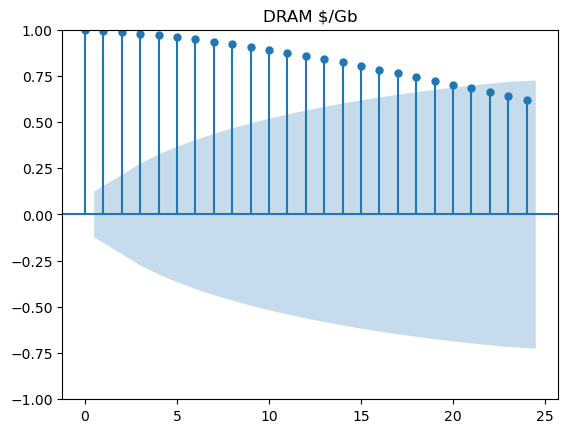

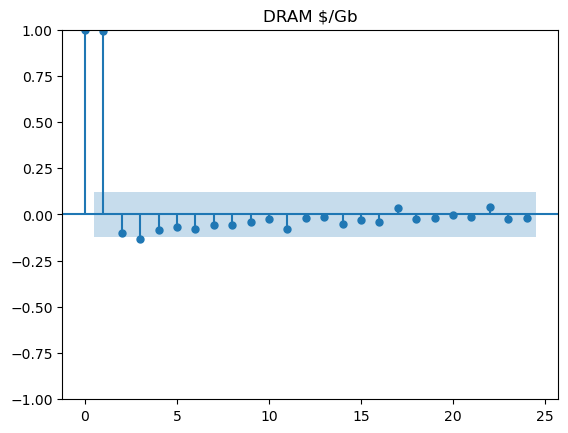

In [1268]:
plot_acf(df5['Avg DRAM $/Gb'], title="DRAM $/Gb")
plot_pacf(df5['Avg DRAM $/Gb'], title="DRAM $/Gb")
plt.show()

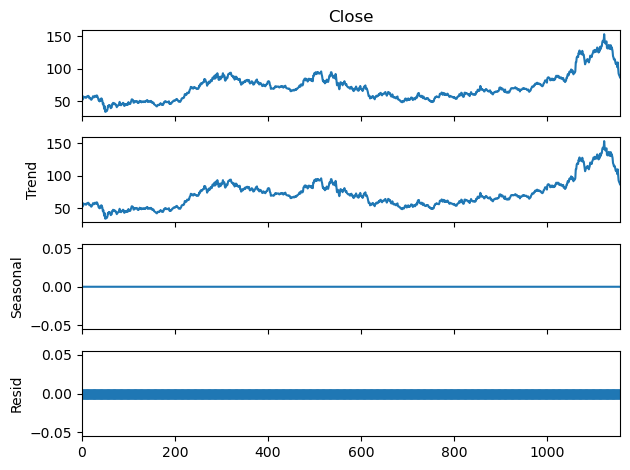

In [1270]:
#Based on the data, we will use the ARIMA later, but first take a look at the seasonality of the data.

decomposed_Micron_stock = sm.tsa.seasonal_decompose(df3["Close"], period=1) # The frequncy is annual
figure = decomposed_Micron_stock.plot()
plt.show()


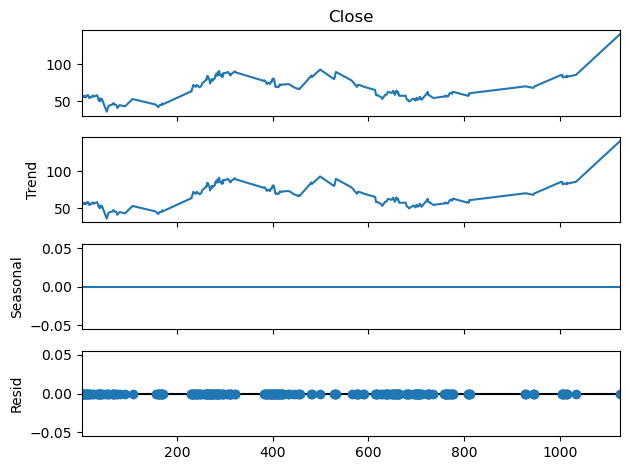

In [1272]:
decomposed_Micron_stock = sm.tsa.seasonal_decompose(df5["Close"], period=1) # The frequncy is annual
figure = decomposed_Micron_stock.plot()
plt.show()

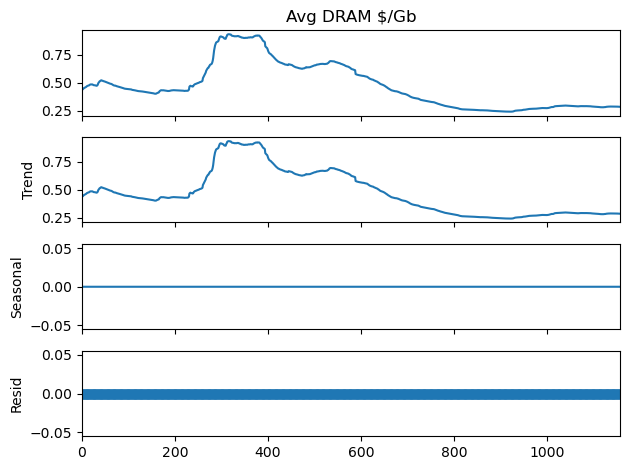

In [1274]:
decomposed_DRAM_Dollar_GB = sm.tsa.seasonal_decompose(df3["Avg DRAM $/Gb"], period=1) # The frequncy is annual
figure = decomposed_DRAM_Dollar_GB.plot()
plt.show()

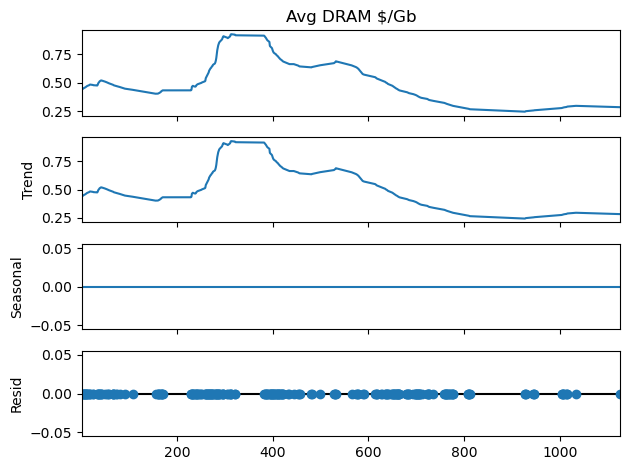

In [1276]:
decomposed_DRAM_Dollar_GB = sm.tsa.seasonal_decompose(df5["Avg DRAM $/Gb"], period=1) # The frequncy is annual
figure = decomposed_DRAM_Dollar_GB.plot()
plt.show()

In [1379]:
# Based on the ACF/PACF and the decomposed seasonality, the data looks like stationary, so MA is the better model to try and fit the data.
y_hist, y_future = train_test_split(df4, shuffle=False)

#y_hist.index = pd.to_datetime(y_hist.index)
y_hist.info()
y_future.info()

<class 'pandas.core.frame.DataFrame'>
Index: 867 entries, 0 to 866
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               867 non-null    float64
 1   Daily % Change      867 non-null    float64
 2   Avg DRAM $/Gb       867 non-null    float64
 3   % Change DRAM $/Gb  866 non-null    float64
dtypes: float64(4)
memory usage: 33.9 KB
<class 'pandas.core.frame.DataFrame'>
Index: 290 entries, 867 to 1156
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               290 non-null    float64
 1   Daily % Change      290 non-null    float64
 2   Avg DRAM $/Gb       290 non-null    float64
 3   % Change DRAM $/Gb  290 non-null    float64
dtypes: float64(4)
memory usage: 11.3 KB


In [1381]:
arma_Close =ARIMA(y_hist['Close'], order = (1, 1, 2)).fit()
hist_preds = arma_Close.predict(start = 0, end =1158)
future_preds = arma_Close.forecast(steps = len(y_future))
hist_preds.info()

<class 'pandas.core.series.Series'>
Index: 1159 entries, 0 to 1158
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
1159 non-null   float64
dtypes: float64(1)
memory usage: 18.1 KB


1154    66.962598
1155    66.962598
1156    66.962598
1157    66.962598
1158    66.962598
Name: predicted_mean, dtype: float64


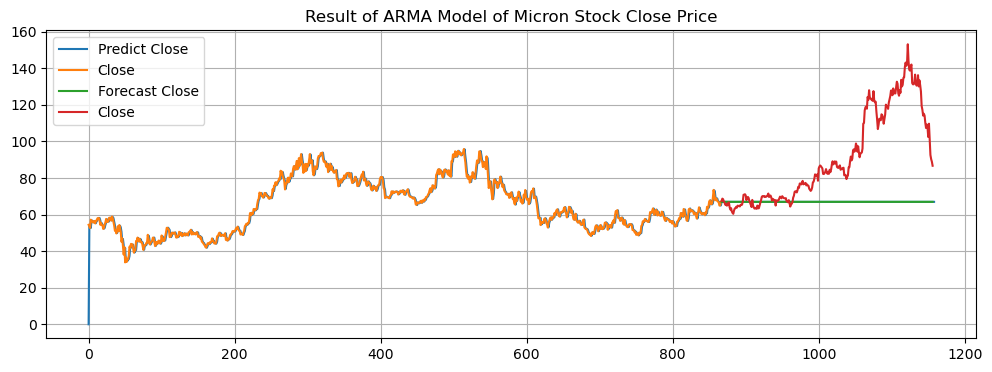

In [1383]:
print(hist_preds.tail())
plt.figure(figsize = (12, 4))
plt.plot(hist_preds, label = 'Predict Close')
plt.plot(y_hist['Close'], label = 'Close')
plt.plot(future_preds, label = 'Forecast Close')
plt.plot(y_future['Close'], label = 'Close')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model of Micron Stock Close Price');

In [1386]:
arma_DRAM =ARIMA(y_hist['Avg DRAM $/Gb'], order = (1, 1, 2)).fit()
hist_preds = arma_DRAM.predict(start =0, end =1158)
future_preds = arma_DRAM.forecast(steps = len(y_future))

1154    0.252209
1155    0.252209
1156    0.252209
1157    0.252209
1158    0.252209
Name: predicted_mean, dtype: float64


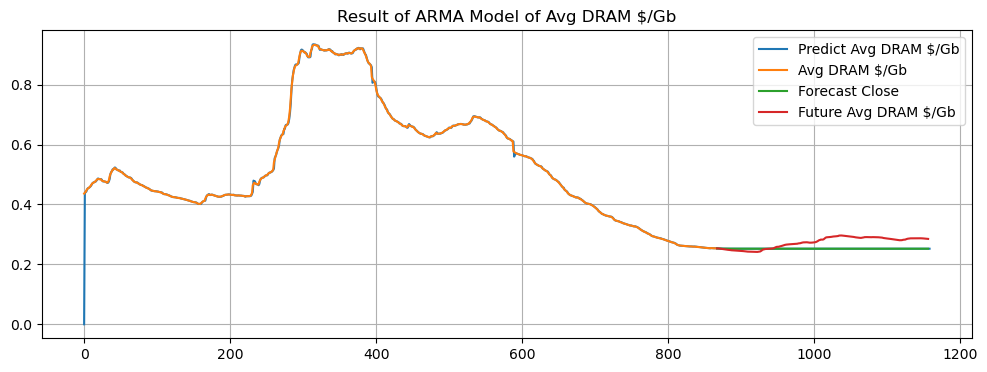

In [1390]:
print(hist_preds.tail())
plt.figure(figsize = (12, 4))
plt.plot(hist_preds, label = 'Predict Avg DRAM $/Gb')
plt.plot(y_hist['Avg DRAM $/Gb'], label = 'Avg DRAM $/Gb')
plt.plot(future_preds, label = 'Forecast Close')
plt.plot(y_future['Avg DRAM $/Gb'], label = 'Future Avg DRAM $/Gb')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model of Avg DRAM $/Gb');